#### Import following modules and setup the other environment variables like GPU processing.

In [ ]:
import torch
import glob
from matplotlib import pyplot as plt
import matplotlib.cm
import torchvision
from sklearn import model_selection
import numpy as np
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

import torch.nn as nn
from torchvision.models import vgg16
from torchvision.models import efficientnet_v2_s


print("device count: ", torch.cuda.device_count())
for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))

print("is Cuda available?: ", torch.cuda.is_available())
device = torch.device('cuda:0')
print(device)

device count:  1
NVIDIA GeForce RTX 3070
is Cuda available?:  True
cuda:0


#### Load Labels/Images from the Dataset

- Import the labels from the Brain Tumor MRI Dataset dataset using the glob module. 
- Retrive all the image pathnames and test one of the images. 
- Extract labels from the image pathnames. 

glioma


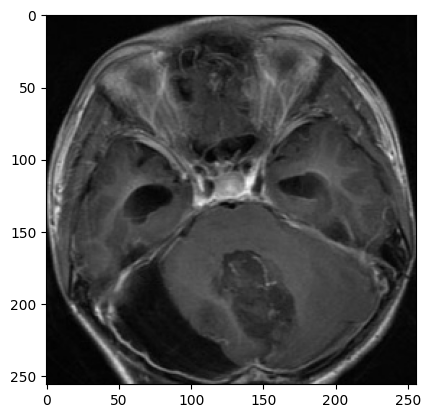

In [ ]:
# image_paths = glob.glob("/Users/uzair/Documents/ENEL645_Final_Project/cleaned-data/TumorCategories/*/*.jpg")
# image_paths = glob.glob("A:\\Software MEng\\winter23\\enel645\\final_project\\cleaned-data\\TumorCategories\\*\\*.jpg")
image_paths = glob.glob("C:\\Users\\mfhfa\\Downloads\\cleaned-data\\TumorCategories\\*\\*.jpg")

image_paths = np.array(image_paths)
image_test = plt.imread(image_paths[0])
plt.imshow(image_test)
print(image_paths[0].split("\\")[-2])
labels = [f.split("\\")[-2] for f in image_paths]
labels_cat = np.array(labels)

#### Transfom labels in to numerical values
- Use LabelEncoder module from sklearn machine learning library.
- Extract and display all the categories of the the labels as well as the total number of labels. 

In [ ]:
enc = LabelEncoder()
enc.fit(y = labels_cat)
print(enc.classes_)
labels_num = enc.transform(labels_cat)
print(labels_num)
print(len(labels_num))

['glioma' 'meningioma' 'notumor' 'pituitary']
[0 0 0 ... 3 3 3]
7023


#### Display Dataset composition
- Display all the categories of the images and the number of items in each category. 
- Display the influence of each category with respect to the entire dataset.

In [ ]:
classes, counts = np.unique(labels, return_counts = True)
for i in range(len(classes)):
    print(classes[i], counts[i], str(round(counts[i]/len(labels)*100, 1)) + "%")

glioma 1621 23.1%
meningioma 1645 23.4%
notumor 2000 28.5%
pituitary 1757 25.0%


#### Shuffle and split the data set into training and testing data
We are going to use the StratifiedShuffleSplit instead of the the normal test train split, to keep the distrubution of the data same within the test
and train sets. 
- 70% of the entire dataset will be training dataset and 30% will be testing dataset.
- Display the size of training and testing dataset. 

In [ ]:
sss_split = model_selection.StratifiedShuffleSplit(test_size = 0.3, random_state = 42)
train_index, test_index = next(sss_split.split(image_paths, labels_num))
train_image_paths = image_paths[train_index]
train_labels = labels_num[train_index]
test_image_paths = image_paths[test_index]
test_labels = labels_num[test_index]

print("training set size: " , train_image_paths.size)
print("test set size: " , test_image_paths.size)

training set size:  4916
test set size:  2107


#### Shuffle and split the training dataset
Now we will split the extracted training dataset further and into train and validation datasets.
- 30% of the training dataset will be assigned to validation dataset. 
- Display the size of the remaining training dataset.
- Display the size of the validation dataset. 

In [ ]:
#similar split will be further done on the training set to split it into the train
#validation set
train_index, valid_index = next(sss_split.split(train_image_paths, train_labels))
train_image_paths = image_paths[train_index]
train_labels = labels_num[train_index]

valid_image_paths = image_paths[valid_index]
valid_labels = labels_num[valid_index]

print("training set size: ", train_image_paths.size)
print("valid set size: ", valid_image_paths.size)

training set size:  3441
valid set size:  1475


#### Image Transformations
- We will be using the torchvision module to create a transformation object.
- Entire dataset will be transformed through a custom built transformation object.
- The first transformation resizes all images in the dataset to a fixed size of (224, 224) pixels. 
- The next transformation converts all the images in the dataset to grayscale images.
- The third transformation converts each image into a PyTorch tensor.
- the last transformation normalizes each tensor by subtracting 0.5 from each pixel value and then dividing it by 0.5.
- All of these transformations are combined into a single object. This object can be applied to a dataset to preprocess the images in the same way, making them ready for use in a machine learning model.

In [ ]:
#entire data set will be transformed through a custom built transformation object
resize = torchvision.transforms.Resize((224,224)) #all images to same size
convert_tensor = torchvision.transforms.ToTensor() #all images to to tensor
grayscale = torchvision.transforms.Grayscale(num_output_channels=1) #all images should be greyscale
normalize = torchvision.transforms.Normalize((0.5,), (0.5,)) #normalize all images
custom_transforms = torchvision.transforms.Compose([resize, grayscale, convert_tensor, normalize])

#### Create training, validation and testing datasets with transformations
- To create data loader objects, we can either create a map-style dataset or iterable-style datasets.
- In this tutorial we will create our datasets using the map-style technique. The iterable-style is more suited where we randomly fectching the data and the batch size is not fixed. For detailed explaination please visit https://pytorch.org/docs/stable/data.html
- To implement a map-style datatset object, we will create our own class that takes the image pathnames, image label and the custom built transformation object as parameters. 
- We must implement our own __getitem__() and __len__() private methods. The torch module will make use of these private methods whenever we attempt to retrieve images and labels from the dataset. 
- Once our custom createDataset class is created. We will initaite the three objects holding training dataset, validation dataset and testing dataset respectively. 

In [ ]:
#we will be choosing to implement a class for map-style dataset that implements the following required methods:
#__getitem()__
#__len()__

class createDataset(torch.utils.data.Dataset):
    def __init__(self, image_paths, labels, transform = None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __getitem__(self, index):

        image = Image.open(self.image_paths[index])

        if self.transform:
            image = self.transform(image)

        return image, self.labels[index]
    
    def __len__(self):
        return len(self.image_paths)

#create all datasets
train_set = createDataset(train_image_paths, train_labels, transform= custom_transforms)
val_set = createDataset(valid_image_paths, valid_labels, transform= custom_transforms)
test_set = createDataset(test_image_paths, test_labels, transform= custom_transforms)

#### Display the Tensor for training dataset
- We pick one of the images from the training dataset and display its Tensor object along with the label. This step is taken to make sure our custom transformation is working. 

In [ ]:
my_iter = iter(train_set)
images_1, labels_1 = next(my_iter)
print(images_1, labels_1)

tensor([[[-0.9686, -0.9686, -0.9608,  ..., -0.9843, -0.9843, -0.9843],
         [-0.9686, -0.9686, -0.9686,  ..., -0.9843, -0.9765, -0.9765],
         [-0.9686, -0.9686, -0.9686,  ..., -0.9765, -0.9686, -0.9686],
         ...,
         [-0.7647, -0.7333, -0.7020,  ..., -0.8510, -0.8510, -0.8588],
         [-0.8431, -0.8196, -0.8039,  ..., -0.8275, -0.8275, -0.8353],
         [-0.9216, -0.9294, -0.9216,  ..., -0.8275, -0.8431, -0.8510]]]) 1


#### Prepare the datasets for training with DataLoaders
The Dataset retrieves our images and labels one by one. While training a model, we would like to pass small batches and reshuffle the data at every epoch to reduce model overfitting.

In [ ]:
#create all dataloader objects
train_dataloader = torch.utils.data.DataLoader(dataset=train_set, batch_size=10, shuffle=False)
val_dataloader = torch.utils.data.DataLoader(dataset=val_set, batch_size=10)
test_dataloader = torch.utils.data.DataLoader(dataset=test_set, batch_size=10)

#### Test the DataLoader object
- The DataLoader object should display the first batch of images and labels. 
- We set the batch size to 10. So we should get 10 images and labels. 

In [ ]:
#Checking to see if dataloader object is working properly
m_iter = iter(test_dataloader)
print(next(m_iter))

[tensor([[[[-0.9059, -0.8980, -0.8980,  ..., -0.9059, -0.8980, -0.8824],
          [-0.8980, -0.8980, -0.8980,  ..., -0.9059, -0.8980, -0.8902],
          [-0.8902, -0.8980, -0.8980,  ..., -0.9059, -0.8980, -0.8902],
          ...,
          [-0.8824, -0.8902, -0.8980,  ..., -0.8902, -0.8980, -0.8980],
          [-0.8824, -0.8902, -0.8980,  ..., -0.8824, -0.8902, -0.8980],
          [-0.8667, -0.8824, -0.8902,  ..., -0.8745, -0.8824, -0.8980]]],


        [[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          ...,
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]]],


        [[[-1.0000, -1.0000, -0.9922,  ..., -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.00

In [ ]:
class CancerNetVGG16(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.num_classes = num_classes
        
        self.model = vgg16() #default no pretrained weights used
        
        # add convolution layer that takes in a image of channel 1 and outputs channel 3
        first_conv_layer = [nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1)]
        # add this to the default model structure
        first_conv_layer.extend(self.model.features)
        self.model.features = nn.Sequential(*first_conv_layer)
        
        # get output shape from the last conv output
        n_feature_from_conv = self._get_conv_output((1,224,224))
        # and pass it on as argument to our custom fully connected last layer
        self.model.fc = torch.nn.Linear(n_feature_from_conv, self.num_classes)

    
    def _get_conv_output(self, shape):
        batch_size = 1
        tmp_input = torch.rand(batch_size, *shape)

        output_feat = self.model(tmp_input) 
        n_size = output_feat.data.view(batch_size, -1).size(1)
        
        return n_size
    
    def forward(self, x):
        x = self.model(x)
        return(x)

In [ ]:
my_model_vgg = CancerNetVGG16(4)
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(my_model_vgg.parameters(), lr=0.001)
my_model_vgg.to(device)
save_path = "CancerNetVGG16.pth"

In [ ]:
num_epochs = 20
best_loss = 10000
train_loss_arr = []
val_loss_arr = []
train_acc_arr = []
val_acc_arr = []

for epoch in range(num_epochs):
    correct = 0
    total = 0
    train_loss = 0
    for i, data in enumerate(train_dataloader, 0):
        images = data[0].to(device)
        labels = data[1].to(device)

        optimizer.zero_grad()

        outputs = my_model_vgg(images)
        labels = labels.long()
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss_arr.append(train_loss/i)
    train_acc_arr.append(100 * correct / total)

    print(f'epoch {epoch + 1}, train loss: {train_loss/i :0.3f}, train acc: {100 * correct / total :0.2f}', end = "")


    correct = 0
    total = 0
    val_loss = 0
    with torch.no_grad():
        for j, data in enumerate(val_dataloader, 0):
            images = data[0].to(device)
            labels = data[1].to(device)

            labels = labels.long()

            val_prediction = my_model_vgg(images)
            loss = loss_function(val_prediction, labels)

            val_loss += loss

            _, predicted = torch.max(val_prediction.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        print(f' validation loss: {val_loss/j:.3f} val acc: {100 * correct / total :0.2f}')

        if val_loss < best_loss:
            print('saving best model')
            torch.save(my_model_vgg.state_dict(), save_path)
            best_loss = val_loss
        
        
        val_loss_arr.append(val_loss.cpu().detach()/j)
        val_acc_arr.append(100 * correct / total)


df_vgg = pd.DataFrame()
df_vgg['train_loss'] = train_loss_arr
df_vgg['train_acc'] = train_acc_arr
df_vgg['val_loss'] = val_loss_arr
df_vgg['val_acc'] = val_acc_arr
df_vgg.to_csv('vgg_training_results.csv')

print('finished training!')

epoch 1, train loss: 1.572, train acc: 32.35 validation loss: 1.113 val acc: 32.68
saving best model
epoch 2, train loss: 1.115, train acc: 34.15 validation loss: 1.110 val acc: 33.69
saving best model
epoch 3, train loss: 1.115, train acc: 33.33 validation loss: 1.113 val acc: 31.53
epoch 4, train loss: 1.110, train acc: 33.74 validation loss: 1.110 val acc: 31.93
epoch 5, train loss: 1.107, train acc: 32.81 validation loss: 1.108 val acc: 32.20
saving best model
epoch 6, train loss: 1.106, train acc: 32.64 validation loss: 1.108 val acc: 32.27
epoch 7, train loss: 1.106, train acc: 33.30 validation loss: 1.109 val acc: 32.54
epoch 8, train loss: 1.106, train acc: 33.45 validation loss: 1.109 val acc: 31.93
epoch 9, train loss: 1.106, train acc: 32.52 validation loss: 1.111 val acc: 32.14
epoch 10, train loss: 1.105, train acc: 32.96 validation loss: 1.111 val acc: 31.59
epoch 11, train loss: 1.104, train acc: 34.67 validation loss: 1.109 val acc: 32.81
epoch 12, train loss: 1.105, tr

In [ ]:
best_model_vgg = CancerNetVGG16(4)
best_model_vgg.load_state_dict(torch.load(save_path))
best_model_vgg.to(device)

CancerNetVGG16(
  (model): VGG(
    (features): Sequential(
      (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): ReLU(inplace=True)
      (13): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (14): ReLU(inplace=True)
      (15): Conv2d(256, 256, kernel_size

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        # images, labels = data
        images = data[0].to(device)
        labels = data[1].to(device)
        # calculate outputs by running images through the network
        outputs = best_model_vgg(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {(100 * correct / total):0.2f} %')

Accuracy of the network on the test images: 23.54 %


In [ ]:
class CancerNetEfficientNetV2(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.num_classes = num_classes
        
        self.model = efficientnet_v2_s() #default no pretrained weights used
        
        # add convolution layer that takes in a image of channel 1 and outputs channel 3
        first_conv_layer = [nn.Conv2d(in_channels=1, out_channels=3, kernel_size=3, padding=1)]
        # add this to the default model structure
        first_conv_layer.extend(self.model.features)
        self.model.features = nn.Sequential(*first_conv_layer)
        
        # get output shape from the last conv output
        n_feature_from_conv = self._get_conv_output((1,224,224))
        # and pass it on as argument to our custom fully connected last layer
        self.model.fc = torch.nn.Linear(n_feature_from_conv, self.num_classes)

    
    def _get_conv_output(self, shape):
        batch_size = 1
        tmp_input = torch.rand(batch_size, *shape)

        output_feat = self.model(tmp_input) 
        n_size = output_feat.data.view(batch_size, -1).size(1)
        
        return n_size
    
    def forward(self, x):
        x = self.model(x)
        return(x)

In [ ]:
my_model_efnv2 = CancerNetEfficientNetV2(4)
optimizer = torch.optim.AdamW(my_model_efnv2.parameters(), lr=0.001, weight_decay=0.05)
loss_function = torch.nn.CrossEntropyLoss()
save_path = "CancerNetEffNetV2.pth"
my_model_efnv2.to(device)

CancerNetEfficientNetV2(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (2): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_si

In [ ]:
num_epochs = 20
best_loss = 10000
train_loss_arr = []
val_loss_arr = []
train_acc_arr = []
val_acc_arr = []

for epoch in range(num_epochs):
    correct = 0
    total = 0
    train_loss = 0
    for i, data in enumerate(train_dataloader, 0):
        images = data[0].to(device)
        labels = data[1].to(device)

        optimizer.zero_grad()

        outputs = my_model_efnv2(images)
        labels = labels.long()
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    train_loss_arr.append(train_loss/i)
    train_acc_arr.append(100 * correct / total)

    print(f'epoch {epoch + 1}, train loss: {train_loss/i :0.3f}, train acc: {100 * correct / total :0.2f}', end = "")

    val_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for j, data in enumerate(val_dataloader, 0):
            images = data[0].to(device)
            labels = data[1].to(device)

            labels = labels.long()

            val_prediction = my_model_efnv2(images)
            loss = loss_function(val_prediction, labels)

            val_loss += loss

            _, predicted = torch.max(val_prediction.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        print(f' validation loss: {val_loss/j:.3f} val acc: {100 * correct / total :0.2f}')

        if val_loss < best_loss:
            print('saving best model')
            torch.save(my_model_efnv2.state_dict(), save_path)
            best_loss = val_loss
        
        
        val_loss_arr.append(val_loss.cpu().detach()/j)
        val_acc_arr.append(100 * correct / total)


df_vgg = pd.DataFrame()
df_vgg['train_loss'] = train_loss_arr
df_vgg['train_acc'] = train_acc_arr
df_vgg['val_loss'] = val_loss_arr
df_vgg['val_acc'] = val_acc_arr
df_vgg.to_csv('effnet_training_results.csv')

print('finished training!')

epoch 1, train loss: 1.083, train acc: 60.07 validation loss: 0.878 val acc: 52.47
saving best model
epoch 2, train loss: 0.765, train acc: 66.03 validation loss: 0.767 val acc: 60.47
saving best model
epoch 3, train loss: 0.684, train acc: 71.72 validation loss: 0.678 val acc: 71.32
saving best model
epoch 4, train loss: 0.627, train acc: 74.08 validation loss: 0.607 val acc: 76.88
saving best model
epoch 5, train loss: 0.563, train acc: 77.04 validation loss: 0.599 val acc: 75.12
saving best model
epoch 6, train loss: 0.529, train acc: 79.13 validation loss: 0.528 val acc: 79.80
saving best model
epoch 7, train loss: 0.482, train acc: 81.92 validation loss: 0.449 val acc: 82.85
saving best model
epoch 8, train loss: 0.447, train acc: 82.80 validation loss: 0.436 val acc: 83.39
saving best model
epoch 9, train loss: 0.380, train acc: 85.24 validation loss: 0.375 val acc: 85.22
saving best model
epoch 10, train loss: 0.354, train acc: 87.01 validation loss: 0.353 val acc: 85.69
saving 

In [ ]:
best_model_env2 = CancerNetEfficientNetV2(4)
best_model_env2.load_state_dict(torch.load(save_path))
best_model_env2.to(device)

CancerNetEfficientNetV2(
  (model): EfficientNet(
    (features): Sequential(
      (0): Conv2d(1, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2dNormActivation(
        (0): Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (2): Sequential(
        (0): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (1): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
          )
          (stochastic_depth): StochasticDepth(p=0.0, mode=row)
        )
        (1): FusedMBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(24, 24, kernel_si

In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_dataloader:
        # images, labels = data
        images = data[0].to(device)
        labels = data[1].to(device)
        # calculate outputs by running images through the network
        outputs = best_model_env2(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the test images: {(100 * correct / total):0.2f} %')

Accuracy of the network on the test images: 70.29 %
